In [24]:
import icarogw
import healpy as hp
import numpy as np
from  astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import scipy
import bilby
from tqdm import tqdm
import h5py
import pandas as pd
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [25]:
# General settings
import matplotlib as mpl
mpl.rc_file('/Users/ulyanadupletsa/Documents/PhDThesisPlots/matplotlibrc')

mpl.rc('xtick', labelsize = 21) 
mpl.rc('ytick', labelsize = 21)

In [26]:
my_color = '#97a7a7'
my_color_darker = '#2f4f4f'
my_color2 = '#f8c997'
my_color2_darker = '#f6b26b'

In [27]:
PATH_TO_DENSITY_MATRIX = '/Users/ulyanadupletsa/Documents/Radio-Sirens/maps_icaro_data/'

In [28]:
np.random.seed(42)

In [29]:
nside = 128
npix = hp.nside2npix(nside)
H0_value = 67.7

# Note the log-uniform grid
lmax = 192

# redhsift range for reference
zmin = 0.005
zmax = 3.025

redshift_grid = np.array([0.005, 0.015, 0.035, 0.06 , 0.085, 0.11 , 0.135, 0.17 , 0.205,
        0.24 , 0.28 , 0.32 , 0.36 , 0.405, 0.455, 0.505, 0.56 , 0.62 ,
        0.68 , 0.745, 0.82 , 0.895, 0.975, 1.06 , 1.155, 1.26 , 1.365,
        1.485, 1.615, 1.755, 1.905, 2.05 , 2.205, 2.39 , 2.585, 2.795,
        3.025])

pixel_grid = np.arange(0, npix, 1).astype(int) # generates an array of (integer) numbers from 0 to npix-1


# Some gaussian fluctation for the density
# density matrix constructed from CLASS output: each row is a different redshift, each column correspond to the density of hydrogen in a pixel
# the number of columns correspond to npix
density_matrix = pd.read_hdf(PATH_TO_DENSITY_MATRIX + 'map4icaro_lmax' + str(lmax) + '_zmin' + str(zmin) + '_zmax' + str(zmax) + '_nside' + str(nside) + '.hdf5').to_numpy()
# Reference cosmology
cosmo_ref = icarogw.cosmology.astropycosmology(zmax=20.)
cosmo_ref.build_cosmology(FlatLambdaCDM(H0=H0_value,Om0=0.308)) # the same used in GADGET!

# Columns are pixel, rows are redshift. The things below are the pixel and redshift
# of each entry of the matrix
# Create a density-matrix-like matrix with the label of pixels in each row
# [[0, 1, 2, ..., npix-1]
# [ ... ]
# [0, 1, 2, ..., npix-1]]
# the number of rows corresponds to the number of redshift bins
pix_mat =  np.tile(np.arange(0,npix,1).astype(int),len(redshift_grid)).reshape(density_matrix.shape)

# Create similar matrix where each row is the same (repeated) redshift value
# [[zbin1, zbin1, ..., zbin1]
# [ ... ]
# [zbinN, zbinN, ..., zbinN]]]
# the number of rows corresponds to the number of redshift bins
# the number of columns equals the number of npix
red_mat =  np.column_stack([redshift_grid for i in range(npix)])

In [30]:

# This is a densiy matrix that is all equal (same of assuming)
# Homogeneity 
density_matrix_dumb = 1e15*np.ones_like(density_matrix) 

In [31]:
# Initialize the density map
HI = icarogw.HI.HI_map(redshift_grid,pixel_grid,density_matrix)
# Initialize the density map (homogeneous)
HI_dumb = icarogw.HI.HI_map(redshift_grid,pixel_grid,density_matrix_dumb)

In [32]:
# Simulate GW Events
Nbinaries = int(1e6) # More or less one year of observation
dlthr = cosmo_ref.z2dl(np.array([3.025])) # this is in Mpc!


# This is the redshift evaluation rate model we use
rw = icarogw.wrappers.rateevolution_Madau()
rw.update(gamma=2.7,kappa=6.,zp=2.)

# Draw more binaries before reweighting
z_injection = np.random.uniform(redshift_grid.min(),redshift_grid.max(),size=10*Nbinaries)
pixel_injection = np.random.randint(len(pixel_grid),size=10*Nbinaries)

# Put the CBCs in local overdensities of the map
log_weights = rw.rate.log_evaluate(z_injection) + np.log(cosmo_ref.dVc_by_dzdOmega_at_z(z_injection)) + \
              np.log(HI.drho_dzdomega(z_injection,pixel_injection,cosmo_ref)) - np.log1p(z_injection)
log_weights = log_weights.flatten()
log_weights-=log_weights.max()
wei = np.exp(log_weights)

np.random.seed(42)

idx_binaries = np.random.choice(len(z_injection),size=Nbinaries,replace=True,p=wei/wei.sum())
pix_injections = pixel_injection[idx_binaries]
ra_injections, dec_injections = icarogw.conversions.indices2radec(pix_injections, nside, nest=False)
red_injections = z_injection[idx_binaries]
dl_injections = cosmo_ref.z2dl(red_injections)
# We save the injections
idx_found = np.where(dl_injections<=dlthr)[0] # We detect stuff below 4.5 Gpc
print('You have {:d} of detected signals'.format(len(np.where(idx_found)[0])))

/var/folders/h7/9cf4n2f137zdvy422j_dnbcw0000gn/T/ipykernel_22968/2499698859.py:16: RuntimeWarning: divide by zero encountered in log
  np.log(HI.drho_dzdomega(z_injection,pixel_injection,cosmo_ref)) - np.log1p(z_injection)


You have 999999 of detected signals


In [33]:
Nevents = 500
posteriors = {}
# choose Nevents from the Nbinaries simulated above
for i in range(Nevents):
    posterior_dict = {'luminosity_distance':np.array([dl_injections[idx_found[i]]]),
                     'right_ascension':np.array([ra_injections[idx_found[i]]]),
                     'declination':np.array([dec_injections[idx_found[i]]])}
    prior = np.ones_like(posterior_dict['luminosity_distance'])
    posteriors[str(i)] = icarogw.posterior_samples.posterior_samples(posterior_dict, prior)
posteriors = icarogw.posterior_samples.posterior_samples_catalog(posteriors)
posteriors.pixelize(nside)

In [34]:
Ninjections = int(5e6)
dl_prior_injections = bilby.prior.PowerLaw(2.,minimum=5,maximum=30000)

injections_dict = {'luminosity_distance':dl_prior_injections.sample(Ninjections),
                  'right_ascension':np.random.uniform(0,2*np.pi,size=Ninjections),
                  'declination':np.arccos(np.random.uniform(-1,1,size=Ninjections))-np.pi/2}

prior = dl_prior_injections.prob(injections_dict['luminosity_distance'])
inj = icarogw.injections.injections(injections_dict, prior, Ninjections, 1.)
print('You have this number of detected injections ', 
      len(np.where(injections_dict['luminosity_distance']<dlthr)[0]))
inj.update_cut(injections_dict['luminosity_distance']<dlthr)
inj.pixelize(nside)

You have this number of detected injections  3384304


In [35]:
cw = icarogw.wrappers.FlatLambdaCDM_wrap(zmax=20.)
rw = icarogw.wrappers.rateevolution_Madau()
rw.update(gamma=2.7,kappa=6.,zp=2.)
rate = icarogw.rates.CBC_HI_vanilla_rate(HI,cw,rw,scale_free=True)
rate_dumb = icarogw.rates.CBC_HI_vanilla_rate(HI_dumb,cw,rw,scale_free=True)

In [36]:
likelihood = icarogw.likelihood.hierarchical_likelihood(posteriors,
                                                       inj,
                                                       rate,
                                                       nparallel=1,
                                                       neffPE=-1, # We are passing one PE, so we remove this flag
                                                       neffINJ=None)

Using 1 samples from each 500 posteriors
Taking 1 posterior samples from 0 that has 1 samples
Taking 1 posterior samples from 1 that has 1 samples
Taking 1 posterior samples from 2 that has 1 samples
Taking 1 posterior samples from 3 that has 1 samples
Taking 1 posterior samples from 4 that has 1 samples
Taking 1 posterior samples from 5 that has 1 samples
Taking 1 posterior samples from 6 that has 1 samples
Taking 1 posterior samples from 7 that has 1 samples
Taking 1 posterior samples from 8 that has 1 samples
Taking 1 posterior samples from 9 that has 1 samples
Taking 1 posterior samples from 10 that has 1 samples
Taking 1 posterior samples from 11 that has 1 samples
Taking 1 posterior samples from 12 that has 1 samples
Taking 1 posterior samples from 13 that has 1 samples
Taking 1 posterior samples from 14 that has 1 samples
Taking 1 posterior samples from 15 that has 1 samples
Taking 1 posterior samples from 16 that has 1 samples
Taking 1 posterior samples from 17 that has 1 sampl

In [37]:
# Running the analysis with the actual density matrix
H0_array = np.linspace(50,80,100)
posterior = np.zeros_like(H0_array)

for i, H0 in tqdm(enumerate(H0_array)):
    likelihood.parameters = {'H0':H0, 'Om0': 0.308,
                            'gamma': 2.7, 'kappa': 6., 'zp': 2.}
    posterior[i] = likelihood.log_likelihood()
posterior-=posterior.max()
posterior=np.exp(posterior)
posterior/=np.trapezoid(posterior)

95it [01:43,  1.09s/it]/opt/miniconda3/envs/healpy/lib/python3.10/site-packages/icarogw/rates.py:1228: RuntimeWarning: invalid value encountered in log
  log_weights=self.rw.rate.log_evaluate(z)+ log_dVc_dz +xp.log(rho_HI) \
100it [01:48,  1.09s/it]


In [38]:
# Running the analysis with costant density matrix
likelihood = icarogw.likelihood.hierarchical_likelihood(posteriors,
                                                       inj,
                                                       rate_dumb,
                                                       nparallel=1,
                                                       neffPE=-1,
                                                       neffINJ=None)

posterior_dumb = np.zeros_like(H0_array)

for i, H0 in tqdm(enumerate(H0_array)):
    likelihood.parameters = {'H0':H0, 'Om0': 0.308,
                            'gamma': 2.7, 'kappa': 6., 'zp': 2.}
    posterior_dumb[i] = likelihood.log_likelihood()
posterior_dumb-=posterior_dumb.max()
posterior_dumb=np.exp(posterior_dumb)
posterior_dumb/=np.trapezoid(posterior_dumb)

Using 1 samples from each 500 posteriors
Taking 1 posterior samples from 0 that has 1 samples
Taking 1 posterior samples from 1 that has 1 samples
Taking 1 posterior samples from 2 that has 1 samples
Taking 1 posterior samples from 3 that has 1 samples
Taking 1 posterior samples from 4 that has 1 samples
Taking 1 posterior samples from 5 that has 1 samples
Taking 1 posterior samples from 6 that has 1 samples
Taking 1 posterior samples from 7 that has 1 samples
Taking 1 posterior samples from 8 that has 1 samples
Taking 1 posterior samples from 9 that has 1 samples
Taking 1 posterior samples from 10 that has 1 samples
Taking 1 posterior samples from 11 that has 1 samples
Taking 1 posterior samples from 12 that has 1 samples
Taking 1 posterior samples from 13 that has 1 samples
Taking 1 posterior samples from 14 that has 1 samples
Taking 1 posterior samples from 15 that has 1 samples
Taking 1 posterior samples from 16 that has 1 samples
Taking 1 posterior samples from 17 that has 1 sampl

100it [01:51,  1.11s/it]


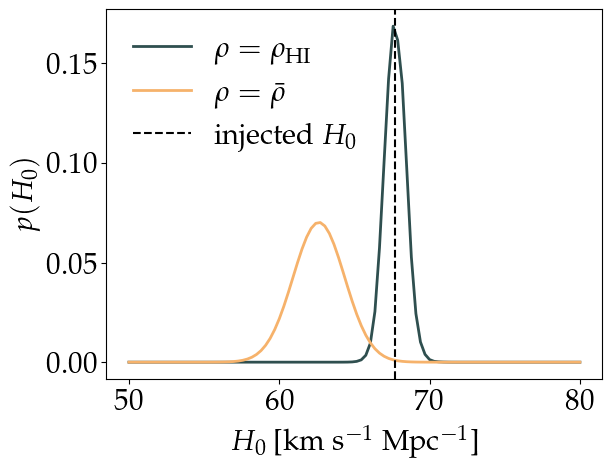

In [ ]:
fig, axs = plt.subplots(1)

plt.plot(H0_array,posterior,label=r'$\rho =\rho_{\rm HI}$', color=my_color_darker, linewidth=2)
plt.plot(H0_array,posterior_dumb,label=r'$\rho = \bar{\rho}$', color=my_color2_darker, linewidth=2)

plt.axvline(H0_value, color='black', linestyle='--', label='injected $H_0$')  

plt.legend(fontsize=21, frameon=False, loc='upper left')#, bbox_to_anchor=(0.5, 1.05))
plt.xlabel(r'$H_0$ [km s$^{-1}$ Mpc$^{-1}$]', fontsize=21)
plt.ylabel(r'$p(H_0)$', fontsize=21)

plt.savefig('plots/H0_radio_estimate.pdf', bbox_inches='tight')
plt.show()